In [1]:
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
import pandas as pd
from datetime import datetime, timedelta, timezone
import time
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.font_manager
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
# Import models
from pyod.models.abod import ABOD
from pyod.models.knn import KNN
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest

## Loading and Reviewing the Data

In [3]:
# reading the dataset
df = pd.read_csv("public/data_source/rca_dataset.csv")
faultsDataFrame = pd.read_csv("public/data_source/ret_info.csv")

In [4]:
df.head(5)

,trace_id,timestamp,latency,succ,source,target
0,2798717183c0df0e9932,1587490000000,0,False,os_021,os_021
1,2798717183c0df0e9932,1587490000000,101,False,None,os_021
2,0af4f17183c0f7fd6282,1587490000000,0,False,os_021,os_021
3,0af4f17183c0f7fd6282,1587490000000,11,False,None,os_021
4,f0f9617183c0fa9f6112,1587490000000,0,False,os_021,os_021


##### Change "succ" from boolean to integer, True=1, False=0

In [5]:
succ_map = {True : 1, False : 0}
df['succ'] = df['succ'].map(succ_map)

##### Converting "timestamp" do datetime

In [6]:
import datetime

df['timestamp'] = df['timestamp'].apply(lambda d: datetime.datetime.fromtimestamp(int(d) / 1000))
timestamp_ = df['timestamp']

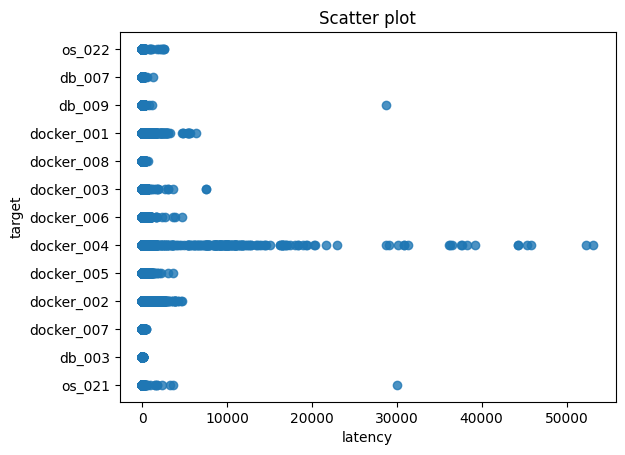

In [7]:
# Plot variables latency and target in a scatter plot
plt.scatter(df.iloc[:, 2], df.iloc[:, 5], alpha=0.8)
plt.title('Scatter plot')
plt.xlabel('latency')
plt.ylabel('target')
plt.show()

In [8]:
df.head(5)

,trace_id,timestamp,latency,succ,source,target
0,2798717183c0df0e9932,2020-04-21 17:26:40,0,0,os_021,os_021
1,2798717183c0df0e9932,2020-04-21 17:26:40,101,0,None,os_021
2,0af4f17183c0f7fd6282,2020-04-21 17:26:40,0,0,os_021,os_021
3,0af4f17183c0f7fd6282,2020-04-21 17:26:40,11,0,None,os_021
4,f0f9617183c0fa9f6112,2020-04-21 17:26:40,0,0,os_021,os_021


##### Converting "target" to Int

In [9]:
le = preprocessing.LabelEncoder()
le.fit(df['target'])
LabelEncoder()
list(le.classes_)
targetTransformed = le.transform(df['target'])

##### Concatenate features that will be used (latency and target)

In [10]:
X1 = df['latency'].values.reshape(-1,1)
X2 = targetTransformed.reshape(-1,1)

X = np.concatenate((X1,X2), axis=1)

#### Algorithms

In [11]:
outliers_fraction = 0.2
# Test 4 different methods
classifiers = {
        #'FeatureBagging': FeatureBagging(contamination=outliers_fraction),
        'KNN': KNN(contamination=outliers_fraction)
        #'HBOS': HBOS(contamination=outliers_fraction),
        #'IForest': IForest(contamination=outliers_fraction)
}

In [12]:
def getConfusionMatrix(actual, predicted):
    import datetime
    
    truePositive = []
    trueNegative = []
    falsePositive = []
    falseNegative = []
    #predicted = predicted.assign(date_time = list(map( lambda x: datetime.fromtimestamp(x/1000), predicted.timestamp)))
    predicted = predicted.assign(date_time = lambda x: df['timestamp'])
    #date_time = datetime.datetime.strptime(date_time,'%Y-%m-%d %H:%M:%S+08:00')
     
    
    for i, act in actual.iterrows(): 
         
         minTime = datetime.datetime.strptime(act.time_preliminary,'%Y-%m-%d %H:%M:%S+08:00') + timedelta(hours=15)
         maxTime = minTime + timedelta(minutes=5)
         
         truePositive.append(predicted.loc[(predicted.date_time  >= minTime) & (predicted.date_time <= maxTime) & (predicted.outliers == 1) & (predicted.target == act.ground_truth)])
         trueNegative.append(predicted.loc[(predicted.date_time < minTime) | (predicted.date_time > maxTime) & (predicted.outliers == 0)])
         falsePositive.append(predicted.loc[(predicted.date_time < minTime) & (predicted.date_time > maxTime) & (predicted.outliers == 1) ])
         falseNegative.append(predicted.loc[(predicted.date_time >= minTime) & (predicted.date_time <= maxTime) & (predicted.outliers == 0) & (predicted.target == act.ground_truth)])
         
         del maxTime, minTime
    
    else: #remove all empty row
        truePositive = list(filter(lambda dfTP: not dfTP.empty, truePositive))        
        trueNegative = list(filter(lambda dfTN: not dfTN.empty, trueNegative))
        falsePositive = list(filter(lambda dfFP: not dfFP.empty, falsePositive))
        falseNegative = list(filter(lambda dfFN: not dfFN.empty, falseNegative))
         
        print("True Positive: ", len(truePositive))
        print("True Negative: ", len(trueNegative))
        print("False Positive: ", len(falsePositive))
        print("False Negative: ", len(falseNegative))
        
    return



""" 
        count = 0
        for i, *trueP in truePositive:
             count = count + len(trueP)
        print("True Positive: ", count)

        count = 0
        for i, *trueN in trueNegative:
             count = count + len(trueN)
        print("True Negative: ", count)

        count = 0
        for i, *falseP in falsePositive:
             count = count + len(falseP)
        print("False Positive: ", count)

        count = 0
        for i, *falseN in falseNegative:
             count = count + len(falseN)
        print("False Negative: ", count)  """
        
     

' \n        count = 0\n        for i, *trueP in truePositive:\n             count = count + len(trueP)\n        print("True Positive: ", count)\n\n        count = 0\n        for i, *trueN in trueNegative:\n             count = count + len(trueN)\n        print("True Negative: ", count)\n\n        count = 0\n        for i, *falseP in falsePositive:\n             count = count + len(falseP)\n        print("False Positive: ", count)\n\n        count = 0\n        for i, *falseN in falseNegative:\n             count = count + len(falseN)\n        print("False Negative: ", count)  '

## Implementation

In [13]:
xx, yy = np.meshgrid(np.linspace(-10, 10, 200), np.linspace(-10, 10, 200))
plt.figure(figsize=(10, 10))

for i, (clf_name, clf) in enumerate(classifiers.items()):

    # Training the model  
    clf.fit(X)

    #  Predicting raw outlier scores
    y_pred = clf.predict(X)

    #  Predict if a particular sample is an outlier or not
    scores_pred = clf.decision_function(X) * -1

    np.unique(y_pred, return_counts=True)

    n_inliers = len(y_pred) - np.count_nonzero(y_pred)
    n_outliers = np.count_nonzero(y_pred == 1)   

    outliers = np.where(y_pred == 1)    
    outliersList = df.iloc[outliers[0], :]

    print('\n\nOUTLIERS : ', n_outliers, 'INLIERS : ', n_inliers, clf_name)
    print(outliersList.head(5))
    
    predicted = df.assign(outliers = y_pred)
    getConfusionMatrix(faultsDataFrame, predicted)





OUTLIERS :  2764 INLIERS :  398480 KNN
                 trace_id           timestamp  latency  succ      source  \
15   9786617183c1125e6128 2020-04-21 17:26:40      904     0        None   
17   81a9517183c1184d1386 2020-04-21 17:26:40      157     0        None   
20   bc31617183c11c516136 2020-04-21 17:26:40    30002     0      os_021   
269  54c6517183dce4579270 2020-04-21 17:26:40      103     0  docker_008   
285  f53c617183dce5ca7836 2020-04-21 17:26:40       97     0  docker_006   

         target  
15       os_021  
17       os_021  
20       os_021  
269  docker_008  
285  docker_006  
True Positive:  0
True Negative:  33
False Positive:  0
False Negative:  0


<Figure size 1000x1000 with 0 Axes>